## Hello! Welcome to a short tutorial on Flow Map Matching

Our aims with this tutorial will be to introduce you to numerical realizations of some of the concepts you've been learning about in class. 

We will build a simple generative model that learns to sample from some 2-dimensional distribution with probability density $\rho_1$. This generative modeling will come in the form of a *map* $T: \mathbb R^2 \rightarrow \mathbb R^2$ that maps samples from a reference distribution with density $\rho_0$. This map will be such that for any $x_0 \sim \rho_0$, the map gives $T(x_0) = x_1 \sim \rho_1$. 

As you have been discussing in class, this map is given by $T(x) = X_{0,1}(x)$, where $X_{s,t}(x)$ is the *flow map* between times $s$ and $t$, which solves the following ordinary differential equation: 

$$ \dot X_{s,t}(x) = b_t(X_{s,t}) \quad \text{such that} \quad  X_{s,s}(x) = x $$

where $b_t(x) : [0,1] \times \mathbb R^d \rightarrow \mathbb R^d$ is a *velocity field* which tells us how the flow map $X_{s,t}(x)$ should instantaneously evolve in magnitude and direction in increments of time $\Delta t$. 

<!-- ![alt text](probflow.png "Flow") -->



Many such flow maps $X_{s,t}(x)$ exist that meet the boundary condition above. We can also ask about the dynamics of the probability density itself endowed by this flow map $X_{s,t}(x)$, rather than just what happens to samples. We say that associatd to $X_t(x)$ is the time dependent density $\rho(t,x)$ so that the pair solve the transport equation:

$$\partial_t \rho_t(x) + \nabla \cdot \big [b_t(x) \rho_t(x) \big] = 0, \quad \text{with} \quad \rho_{t=0} = \rho_0 \text{ and } \rho_{t=1} = \rho_1 $$

which says that mass is conserved and the transport starts and ends in the right place. 

##### For most distributions, we don't know what the flow map $X_{s,t}(x)$ is ahead of time and must try to *estimate* it over a parametric function class. What you'll define below is a way to do this using the method of stochastic interpolants, which gives us a way to sample a time dependent density $\rho_t(x)$ and learn the $X_{s,t}(x)$ that performs the associated mapping.

Let's lay out the steps to do this in code. Here's what we'll need:

- a python package that allows us to perform optimization over our parametric functions using autodifferentiation: PyTorch
- A way to define and sample under the probability densities $\rho_0$ and $\rho_1$
- A neural network that we will use as our model of the map $\hat X_{s,t}(x)$
- An implementation of the stochastic interpolant and the associated optimization loop used in conjunction with it to fit $\hat X_{s,t}(x)$ to the true $\hat X_{s,t}(x)$.
- Some visualizations of the results!

### Software pre-requisites

In [1]:
try:
    import numpy as np
    import matplotlib.pyplot as plt
    import torch  # 2.0 or greater
    from torch.func import vmap
    from torch.func import jacfwd
    
    print("All packages are installed!")
except ImportError as e:
    print(f"An error occurred: {e}. Please make sure all required packages are installed.")

    
from typing import Callable
import math

# from scipy.stats import entropy

All packages are installed!


In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(torch.backends.mps.is_available())

True


In [3]:
def grab(var):
    return var.detach().cpu().numpy()

### Defining and sampling our two distributions

To learn a generative model to sample under $\rho_1$, we first need to define what distribution we want to sample from and what distribution we start from!

Let's say that our data is in $\mathbb R^2$. We will take $\rho_0$ as a Normal distribution with mean vector $m = (0,0)$ and identity covariance $C = Id$ so that $\rho_0 \equiv \mathsf N(0, Id)$.



In [4]:
import torch
from torch.distributions import MultivariateNormal

class BaseDistribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.covariance = cov
        self.distribution = MultivariateNormal(mean, cov)
    
    def sample(self, n=1):
        """
        Draws $n$ samples from the Gaussian distribution.   
        """
        return self.distribution.sample((n,))
    
    def log_prob(self, x):
        """
        Evaluates the log probability of given samples $x$ under the distribution. 
        """
        return self.distribution.log_prob(x)

mean = torch.tensor([0.0, 0.0])  # \mu \in R^2
cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # \Sigma \in R^{2x2}

base = BaseDistribution(mean, cov)

#### Let's choose our target distribution to be: a checkerboard in in 2d space or a Gaussian Mixture defined as follows:



#### Checker

In [5]:
# # checker
# ndim = 2
# def target(bs):
#     x1 = torch.rand(bs) * 4 - 2
#     x2_ = torch.rand(bs) - torch.randint(2, (bs,)) * 2
#     x2 = x2_ + (torch.floor(x1) % 2)
#     return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


# # target = GMM(mus_target, var_target)
# target_samples  = target(10000)

# fig = plt.figure(figsize=(6,6))
# plt.hist2d(grab(target_samples[:,0]), grab(target_samples[:,1]), bins = 100, range=[[-9,9],[-9,9]]);
# plt.title("Multimodal Target")
# plt.show()


#### Mixture of Gaussians, if you want to use it instead as a target.

In [9]:
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from torch.distributions.multivariate_normal import  MultivariateNormal




class Prior(torch.nn.Module):
    """
    Abstract class for prior distributions of normalizing flows. The interface
    is similar to `torch.distributions.distribution.Distribution`, but batching
    is treated differently. Parameters passed to constructors are never batched,
    but are aware of the target (single) sample shape. The `forward` method then
    accepts just the batch size and produces a batch of samples of the known
    shape.
    """
    def forward(self, batch_size):
        raise NotImplementedError()
    def log_prob(self, x):
        raise NotImplementedError()
    def draw(self, batch_size):
        """Alias of `forward` to allow explicit calls."""
        return self.forward(batch_size)
    

    
class GMM(Prior):
    def __init__(self, loc=None, var=None, scale = 1.0, ndim = None, nmix= None, device='cpu', requires_grad=False):
        super().__init__()
        
        self.device = device
        self.scale = scale       ### only specify if loc is None
        def _compute_mu(ndim):
                return self.scale*torch.randn((1,ndim))
                        
        if loc is None:
            self.nmix = nmix
            self.ndim = ndim 
            loc = torch.cat([_compute_mu(ndim) for i in range(1, self.nmix + 1)], dim=0)
            var = torch.stack([1.0*torch.ones((ndim,)) for i in range(nmix)])
        else:
            self.nmix = loc.shape[0]
            self.ndim = loc.shape[1] ### locs should have shape [n_mix, ndim]
            
        self.loc = loc   ### locs should have shape [n_mix, ndim]
        self.var = var   ### should have shape [n_mix, ndim]
        
        if requires_grad:
            self.loc.requires_grad_()
            self.var.requires_grad_()
        
        mix = Categorical(torch.ones(self.nmix,))
        comp = Independent(Normal(
                     self.loc, self.var), 1)
        self.dist = MixtureSameFamily(mix, comp)
        
    def log_prob(self, x):
        logp = self.dist.log_prob(x)
        return logp
    
    
    def forward(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x
    
    def rsample(self, batch_size):
        x = self.dist.rsample((batch_size,))
        return x
    
nmix = 8
ndim = 2
def _compute_mu(i):
            return 5.0 * torch.Tensor([[
                        torch.tensor(i * math.pi / 4).sin(),
                        torch.tensor(i * math.pi / 4).cos()]])
mus_target = torch.stack([_compute_mu(i) for i in range(nmix)]).squeeze(1)
var_target = torch.stack([torch.tensor([0.7, 0.7]) for i in range(nmix)])


target = GMM(mus_target, var_target)

#### Below we can visualize both of the distributions by drawing samples from them and plotting them

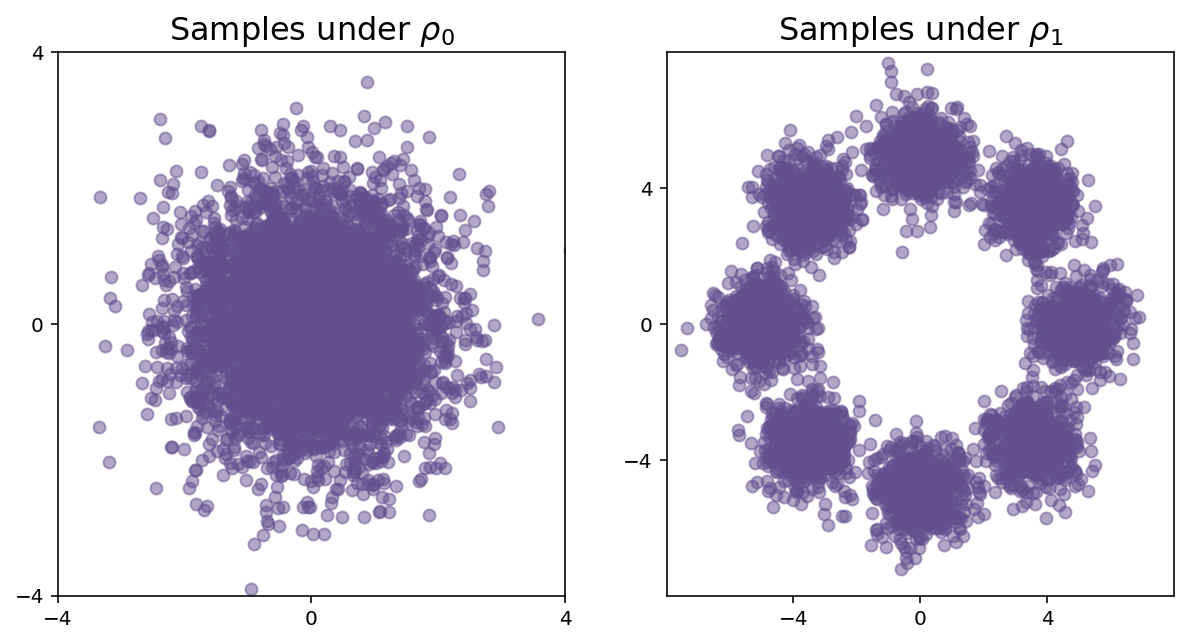

In [10]:
bs = 5000
c = '#62508f' # plot color

x0s = base.sample(bs).detach().numpy()
x1s = target(bs).detach().numpy()

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax0.scatter(x0s[:,0], x0s[:,1], alpha = 0.5, c = c)
ax0.set_xlim(-4,4), ax0.set_ylim(-4,4)
ax0.set_title(r"Samples under $\rho_0$", fontsize = 16)
ax0.set_xticks([-4,0,4]), ax0.set_yticks([-4,0,4])

ax1.scatter(x1s[:,0], x1s[:,1], alpha = 0.5, c = c)
ax1.set_xlim(-8,8), ax1.set_ylim(-8,8)
ax1.set_title(r"Samples under $\rho_1$", fontsize = 16)
ax1.set_xticks([-4,0,4]), ax1.set_yticks([-4,0,4]);

## Building a map between $\rho_0$ and $\rho_1$ with the interpolant

You have been learning in class that you can use the method of stochastic interpolants to define a time dependent density $\rho_t(x)$ that connects $\rho_0$ to $\rho_1$ and allows us to learn the associated velocity field $b_t(x)$ that would map samples from one to samples from another.

Let's introduce the interpolant function here and make some statements about it. The stochastic interpolant $I_t$ is a stochastic process given as:

$$ I_t  = \alpha_t x_0 + \beta_t x_1 \quad \text{where} x_0 \sim \rho_0 \text{ and } x_1 \sim \rho_1 $$ 

 - When $x_0, x_1$ are drawn accordingly, we say that the stochastic interpolant $x(t)$ is a sample under the time dependent density i.e. $I_t \sim \rho_t(x)$. 
 - The velocity field associated to this $\rho_t(x)$ is given by the conditional expectation of the time dynamics of the interpolant, namely: 
 
 $$ b_t(x) = \mathbb E[ \dot I_t | I_t = x]$$

 - The probability flow is the solution to the ODE

$$ \dot X_{s,t}(x) = b_t(X_{s,t}(x)), \qquad X_{s,s}(x) = x$$
where the dot denote deriavtive with respect to $t$.

 
What do we mean when we say $I_t$ samples $\rho_t(x)$ well let's take a look by implementing it. We will make a class called `Interpolant` that implements $I_t$ and it's time derivative.



In [11]:
## using alpha(t) = (1-t) and beta(t) = t
class Interpolant:
    def alpha(self, t):
        return 1.0 - t
    
    def dotalpha(self, t):
        return -1.0
    
    def beta(self, t):
        return t
    
    def dotbeta(self, t):
        return 1.0
    
    def _single_xt(self, x0, x1, t):
        return self.alpha(t)*x0 + self.beta(t)*x1
    
    def _single_dtxt(self, x0, x1, t):
        return self.dotalpha(t)*x0 + self.dotbeta(t)*x1
    
    def xt(self, x0, x1, t):
        return vmap(self._single_xt, in_dims=(0, 0, 0))(x0,x1,t)
    
    def dtxt(self, x0, x1, t):
        return vmap(self._single_dtxt, in_dims=(0, 0, 0))(x0,x1,t)
    
    
interpolant = Interpolant()

bs  = 5000
x0s = base.sample(bs)
x1s = target(bs)
t   = 0.2*torch.ones(bs)

xts = interpolant.xt(x0s, x1s, t)


In the above code, we implement the interpolant for a single sample of $x_0, x_1$, and $t$, which have shape `[d], [d], [1]` respectively. Then, we use a tool in pytorch called `vmap` which allows us to generalize the code for arbitrary *batches* of samples of $x_0, x_1$ and $t$. That way, if we have $N$ samples of $x_0, x_1$ and $t$, we can compute the interpolant for all $N$ of them at once using vmap.

This means we can feed the function `interpolant.xt` a batch of samples of shape `[N, d]` for $x_0$ and $x_1$ and of shape `[N]` for time.

Let's see what happens when we sample $\rho_t(x)$ at various times along $[0,1]$:

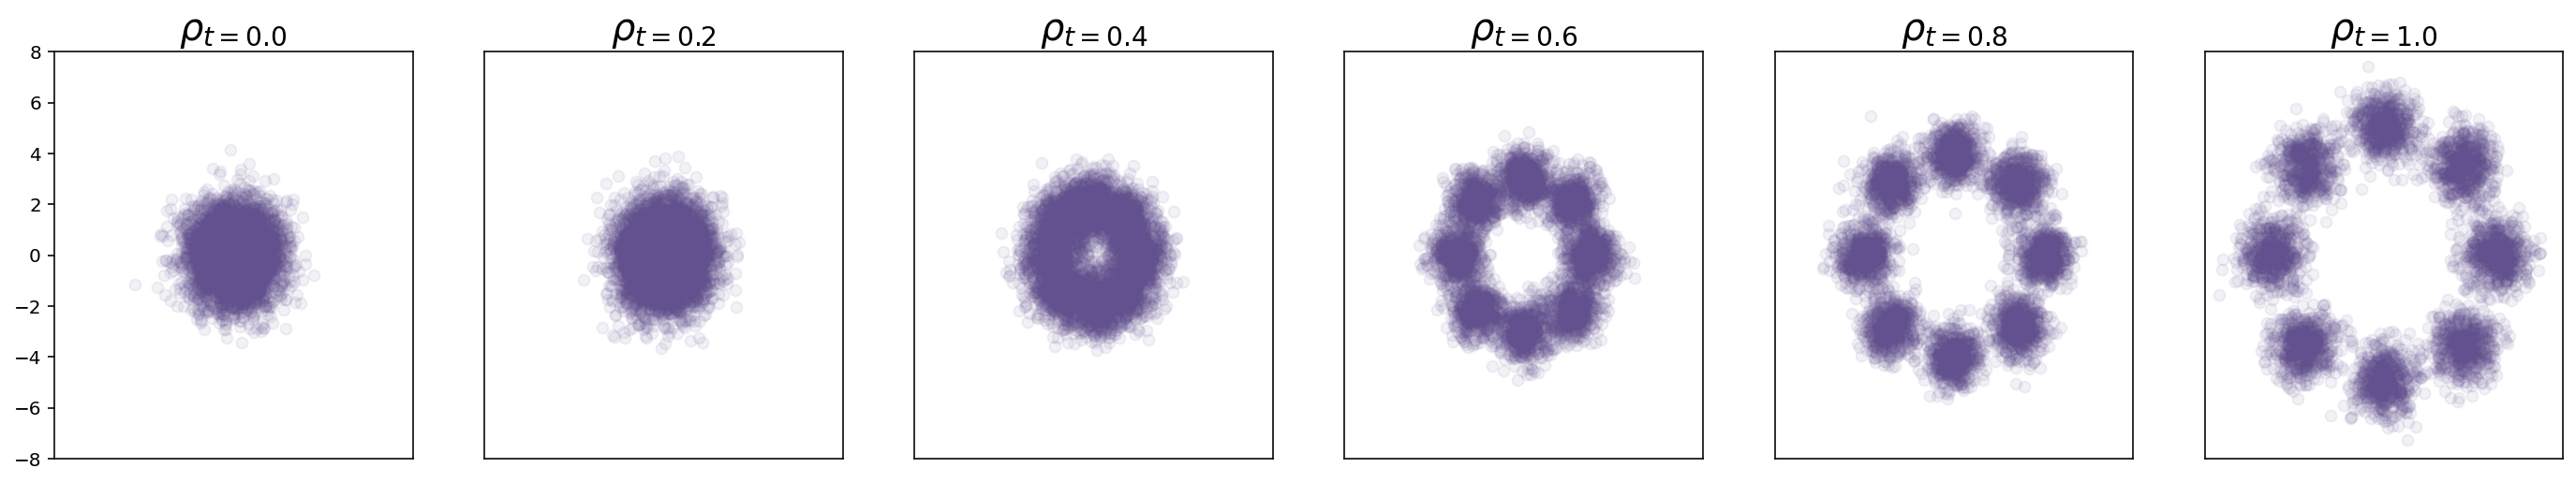

In [12]:
bs = 5000
ncol = 6
ts   = torch.linspace(0, 1, ncol)
c = '#62508f'

fig, axes = plt.subplots(1, ncol, figsize=(ncol*4,4))

for i, t in enumerate(ts):
    
    
    tt  = t.repeat(bs)
    x0s = base.sample(bs)
    x1s = target(bs)
    xts = interpolant.xt(x0s, x1s, tt)
    
    axes[i].scatter(xts[:,0], xts[:,1], alpha = 0.08, c = c) # plot samples x_t \sim \rho_t
    
    axes[i].set_xticks([])
    axes[i].set_title(r'$\rho_{t = %.1f}$' % t, fontsize = 20, weight='bold')
    axes[i].set_xlim(-8,8)
    axes[i].set_ylim(-8,8)
    
    if i !=0:
        axes[i].set_yticks([])



### Learning $b_t(x)$ with the interpolant

Let's parameterize $b_t(x)$ as a feedforward neural network.

In [14]:
from torch.func import jacrev, grad

class VelocityField(torch.nn.Module):
    # a neural network that takes x in R^d and t in [0, 1] and outputs a a value in R^d
    def __init__(self, d,  hidden_sizes = [256, 256], activation=torch.nn.ReLU):
        super(VelocityField, self).__init__()
        
        layers = []
        prev_dim = d + 1  #
        for hidden_size in hidden_sizes:
            layers.append(torch.nn.Linear(prev_dim, hidden_size))
            layers.append(activation())
            prev_dim = hidden_size  # Update last_dim for the next layer

        # final layer
        layers.append(torch.nn.Linear(prev_dim, d))
        
        # Wrap all layers in a Sequential module
        self.net = torch.nn.Sequential(*layers)
    
    def _single_forward(self, x, t):  
        t = t.unsqueeze(-1)
        return self.net(torch.cat((x, t)))
    
    def forward(self, x, t):
        return vmap(self._single_forward, in_dims=(0,0), out_dims=(0))(x,t)
    
    

    

In [15]:
d = 2
b =  VelocityField(d, hidden_sizes=[512, 512, 512])


bs = 10 ## simple test batch size
x = torch.rand(bs, d)
t = torch.rand(bs)

print(x.shape)
print(t.shape)

out = b.forward(x,t) ## should output something of shape [bs, d]

t = t.requires_grad_(True)
print(t.requires_grad)
# print(dtout==dtout_n)


torch.Size([10, 2])
torch.Size([10])
True


### Loss function and learning

Now that we have a suitable neural network to optimize, we need to specify the learning rule to update the weights of $\hat b_t(x)$.

In class you've learned the the velocity field of the interpolant, $b_t(x) = \mathbb E [ \dot I_t | I_t = x]$ is the unique minimizer of the least squares loss given by:

$$ \mathcal L[\hat b] = \int_0^1 \mathbb E_{x_0, x_1}| \hat b(t,I_t)  - \dot I_t|^2 dt$$ where expectation is taken over $x_0, x_1$.

Let's go ahead and implement this in code:

In [17]:
def _single_loss(b, interpolant, x0, x1, t):
    """
    Interpolant loss function for a single datapoint of (x0, x1, t).
    """
    It   = interpolant._single_xt(  x0, x1, t)
    dtIt = interpolant._single_dtxt(x0, x1, t)
    
    bt          = b._single_forward(It, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt) * bt)
    return loss


loss_fn = vmap(_single_loss, in_dims=(None, None, 0, 0, 0), out_dims=(0), randomness='different')

N = 10
x0s = base.sample(N)
x1s = target(N)
ts  = torch.rand(N)
loss_fn(b, interpolant, x0s, x1s, ts).mean()

# loss_fn = vmap(_single_loss, in_dims=(None, None, 0, 0, 0), out_dims=(0), randomness='different')

tensor(-0.0041, grad_fn=<MeanBackward0>)

#### Training step

Now that we have constructed our loss, let's put it in a loop to interatively update the parameters of $\hat b$ as we move toward the minimizer of $\mathcal L[\hat b]$. 

To perform this parameter update, we need to introduce a pytorch `optimizer` that performs the gradient update for us. We do that via the following, specifying a learning rate `lr`. We use the `Adam` optimizer, which is a fancier version of SGD.

In [19]:
lrb = 2e-3 ## learning rate
opt = torch.optim.Adam([
    {'params': b.parameters(), 'lr': lrb} ])
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=1500, gamma=0.6)

A training step:

In [20]:
def train_step(b, interpolant, opt, sched, N):
    
    ## draw N samples form each distribtuion and from time uniformly
    x0s = base.sample(N)
    x1s = target(N)
    ts  = torch.rand(N)
    
    # evaluate loss 
    loss_val = loss_fn(b, interpolant, x0s, x1s, ts).mean()
    
    # perform backprop
    loss_val.backward()
    opt.step()
    sched.step()
    opt.zero_grad()
    
    res = {
            'loss': loss_val.detach(),
        }
    return res

#### Run the training!

In [21]:
n_opt = 5000
bs    = 2500

In [22]:
losses_b = []
from tqdm import tqdm
pbar = tqdm(range(n_opt))
for i in pbar:
    
    res = train_step(b, interpolant, opt, sched, bs)
    loss = res['loss'].detach().numpy().mean()
    
    losses_b.append(loss)
    pbar.set_description(f'Loss: {loss:.4f}')

Loss: -8.6113: 100%|██████████| 5000/5000 [01:41<00:00, 49.39it/s]


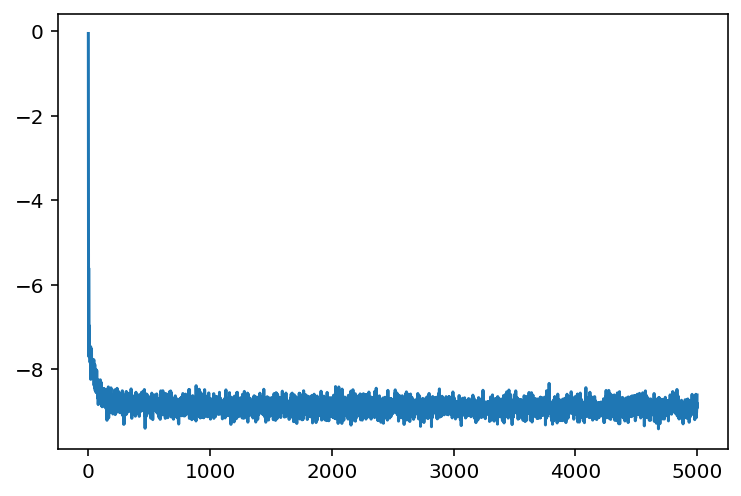

In [23]:
plt.plot(losses_b)

### Implementing the ODE integrator

Now that we've learned $b_t(x)$, we can use it in the probability flow ODE 

$$ \dot X_t(x) = b_t(X_t(x)) $$

to get our generative model. To solve this ODE, we will use the Euler method, and iterate on the procedure:

$$ X_{t + \Delta t} = X_t + \Delta t \, b_t(X_t), \qquad X_{t=0} \sim \rho_0, \qquad  $$

We will do this with the following class called `ODEIntegrator` which implements the iterative step and performs the rollout over the interval $t \in [0,1]$.

*We may ultimately want a few to one step map, and don't want to use this ODE integrator. After this we will return to learning the map $ X_{s,t}(x)$ based on our knowledge of $b$.*

In [47]:

class ODE:
    def __init__(self, b, interpolant, n_step):
        
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.ts          = torch.linspace(0.0,1.0, n_step + 1)
        self.dt          = self.ts[1] - self.ts[0]
    
    
    
    def step(self, x, t):
        return x + self.b(x, t)*self.dt 
    
    def solve(self, x_init):
        
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape))
        x = x_init
        for i,t in enumerate(self.ts[:-1]):
            t = t.repeat(len(x))
            x = self.step(x,t)
            xs[i] = x
        return xs
    
    
ode  = ODE(b.to('cpu'), interpolant, n_step = 80)


x_init = base.sample(20000)
xfs    = ode.solve(x_init)
x1s_b = xfs[-1].detach().numpy()

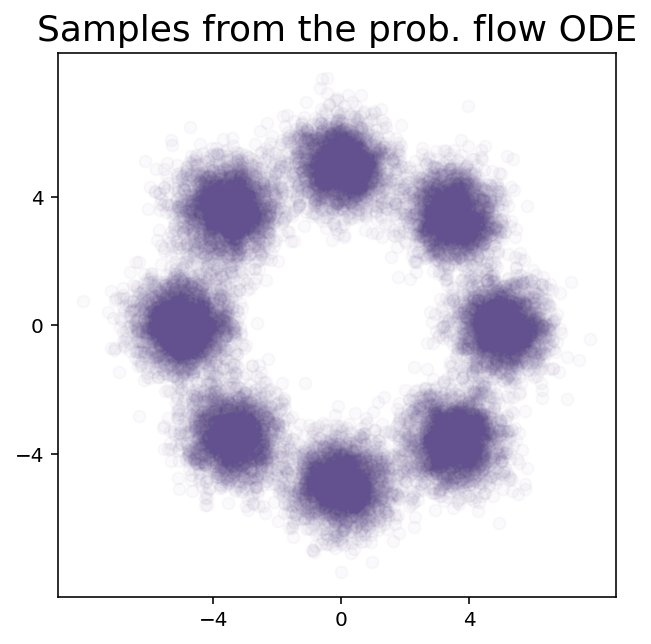

In [48]:
c = '#62508f' # plot color
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(x1s_b[:,0], x1s_b[:,1], alpha = 0.03, c = c)
ax.set_title(r"Samples from the prob. flow ODE", fontsize = 18)
ax.set_xticks([-4,0,4]), ax.set_yticks([-4,0,4]);

### Learning the Flow Map from $\hat b_t(x)$: Neural Network $\hat X_{s,t}(x)$ to model $X_{s,t}(x)$

Now we need to define a neural network which has learnable parameters to model $X_{s,t}(x)$. Recall that this map takes in two time coordinates and a spatial sample which is $\mathbb R^2$. This means that our neural network approximation $\hat X_{s,t}(x)$ should be a function that has an input size of $2 + \text{space dim} = 4$ and should have an output dimension of $\text{space dim} = 2$. 

To define a neural network, we'll use PyTorch's `torch.nn.Module` library which allows us to compose parts of the neural network in a way that allows us to take derivatives with respect to the networks weights:

In [28]:
from torch.func import jacrev, grad    
    
class FlowMap(torch.nn.Module):
    # a neural network that takes x in R^d and (s,t) in [0, 1]^2 and outputs a a value in R^d
    def __init__(self, d,  hidden_sizes = [256, 256, 256], activation=torch.nn.SiLU):
        super(FlowMap, self).__init__()
        
        
        ## feedforward network
        layers = []
        prev_dim = d + 2  
        for hidden_size in hidden_sizes:
            layers.append(torch.nn.Linear(prev_dim, hidden_size))
            layers.append(activation())
            prev_dim = hidden_size  

        # final layer
        layers.append(torch.nn.Linear(prev_dim, d))
        
        self.net = torch.nn.Sequential(*layers)
    
    def _single_forward(self, x, s, t):  
        s = s.unsqueeze(-1)
        t = t.unsqueeze(-1)
        return self.net(torch.cat((x, s, t)))
    
    def forward(self, x, s, t):
        return vmap(self._single_forward, in_dims=(0,0,0), out_dims=(0))(x,s,t)
    
    def _single_Xst(self, x0, s, t):
        """
        A function that implements: X(s,t,x) = (1-(t-s))*x0 + (t-s)*f(s,t,x)
        where f(s,t,x) is a neural network.
        
        This functional form ensures the boundary condition that X(s,s,x) = x0
        """
        return (1-t+s)*x0 + (t-s)*self._single_forward(x0,s,t)
    
    def Xst(self, x0, s, t):
        return vmap(self._single_Xst, in_dims=(0,0,0), out_dims=(0))(x0,s,t)
    
    def _single_dtXst(self, x0, s, t):
        return -x0 + self._single_forward(x0,s,t) + (t-s)*self._single_dt(x0,s,t)   
    
    def dtXst(self, x0, s, t):
        return vmap(self._single_dtXst, in_dims=(0,0,0), out_dims=(0))(x0,s,t)
    
    def _single_dt(self, x, s, t):
        
        ## use if using 'cuda' or 'cpu'
        # gradt = jacfwd(self._single_forward, 2)(x,s,t)
        
        ## or approximate by finite difference
        ## use if using 'mps'
        dt = torch.tensor(0.001)
        gradt = .5*(self._single_forward(x,s,t+dt) - self._single_forward(x,s,t-dt))/dt
        return gradt

In [29]:

class MAP:
    def __init__(self, T, interpolant, n_step, rev = False):
        
        self.T           = T
        self.interpolant = interpolant
        self.n_step      = n_step
        self.ts          = torch.linspace(0.0,1.0, n_step + 1).to(device)
        if rev == True:
            self.ts = torch.flip(self.ts, dims=[0])   
    
    
    def step(self, x, s, t):
        return  self.T.Xst(x, s, t) 
    
    def solve(self, x_init):
        
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape)).to(device)
        x = x_init
        for i,t in enumerate(self.ts[:-1]):
            s = t.repeat(len(x)).to(device)
            t = self.ts[i+1].repeat(len(x))
            # print(s,t)
            x = self.step(x,s,t)
            xs[i] = x
        return xs
    
    

Let's check to make sure our neural network class works by making some fake data and seeing that it outputs something of the right shape

In [30]:
d = 2
T =  FlowMap(d, hidden_sizes=[512, 512, 512, 512, 512, 512]).to(device)

bs = 20000 ## simple test batch size
x = torch.rand(bs, d).to(device)
s = torch.rand(bs).to(device)
t = torch.rand(bs).to(device)

print(x.shape)
print(s.shape)
print(t.shape)

t = t.requires_grad_(True)
print(t.requires_grad)

import time
tic = time.perf_counter()
out = T.Xst(x,s,t)
toc = time.perf_counter()
print("time with cpu:", toc-tic, " sec")
print(out)

torch.Size([20000, 2])
torch.Size([20000])
torch.Size([20000])
True
time with cpu: 0.19032008300018788  sec
tensor([[1.1779, 0.7177],
        [0.0964, 0.0859],
        [0.3439, 0.2000],
        ...,
        [0.6001, 0.4678],
        [0.4979, 0.6472],
        [0.4603, 0.5808]], device='mps:0', grad_fn=<AddBackward0>)


### Loss function and learning

Now that we have a suitable neural network to optimize, and we have a $b(t,x)$ to distill, we need to specify the learning rule to update the weights of $\hat X_{s,t}(x)$.

Map distillation loss function for a single datapoint of (x0, x1, s, t).
Uses the Lagrangian formulation (s < t):
$$\int_0^1 dt \int_0^t ds \mathbb E[|\partial_t X_{s,t}(I_s) - b_t(X_{s,t}(I_s))|^2] $$

Let's go ahead and implement this in code:

In [34]:
def _single_loss_distill_lagrange(T, b, interpolant, x0, x1, s, t):
    """
    Map distillation loss function for a single datapoint of (x0, x1, s, t).
    Uses the Lagrangian formulation (s < t):
    \int_0^1 dt \int_0^t ds E[|\partial_t X_{s,t}(I_s) - b_t(X_{s,t}(I_s))|^2] 
    """
    Is          = interpolant._single_xt(x0, x1, s)
    
    Xst = T._single_Xst(Is, s, t)
    dtXst  = T._single_dtXst(Is, s, t)
    with torch.no_grad():
        btx   = b._single_forward(Xst, t)
    loss = ((dtXst - btx)**2).sum()


    return loss

In [35]:
loss_fn = vmap(_single_loss_distill_lagrange, in_dims=(None, None, None, 0, 0, 0, 0), out_dims=(0), randomness='different')

### Training step

Now that we have constructed our loss, let's put it in a loop to interatively update the parameters of $\hat X_{s,t}(x)$ as we move toward the minimizer of $\mathcal L[\hat X]$. 

To perform this parameter update, we need to introduce a pytorch `optimizer` that performs the gradient update for us. We do that via the following, specifying a learning rate `lr`. We use the `Adam` optimizer, which is a fancier version of SGD.

In [36]:
lr = 2e-4 ## learning rate
opt = torch.optim.Adam([
    {'params': T.parameters(), 'lr': lr} ])
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=2500, gamma=0.92)

Now lets use it in a function called `train_step` which will perform our iteration:

In [40]:
def train_step_c(T, b, interpolant, opt, sched, N, k):
    
    ## draw N samples form each distribtution and from time uniformly
    x0s = base.sample(N).to(device)
    x1s = target(N).to(device)
    ts = torch.rand(N).to(device)
    ss = ts*torch.rand(N).to(device)
    

    # evaluate loss 
    loss_val = loss_fn(T, b, interpolant, x0s, x1s, ss, ts).mean()
    
    # perform backprop
    loss_val.backward()
    opt.step()
    sched.step()
    opt.zero_grad()
    
    res = {
            'loss': loss_val.detach().cpu(),
        }
    return res

#### Running the Training

We are now ready to train our model. Let's build a loop that runs for `n_opt` steps and store the loss over time.

In [41]:
losses_c = []

In [44]:
n_opt = 50000
bs    = 2500
b = b.to(device)

In [45]:
from tqdm import tqdm
pbar = tqdm(range(n_opt))
for i in pbar:

    res = train_step_c(T, b, interpolant, opt, sched, bs, k = 0.25)
    loss = res['loss'].detach().numpy().mean()
    
    losses_c.append(loss)
    pbar.set_description(f'Loss: {loss:.4f}')

Loss: 0.0142:   6%|▋         | 3140/50000 [02:24<35:57, 21.72it/s]


KeyboardInterrupt: 

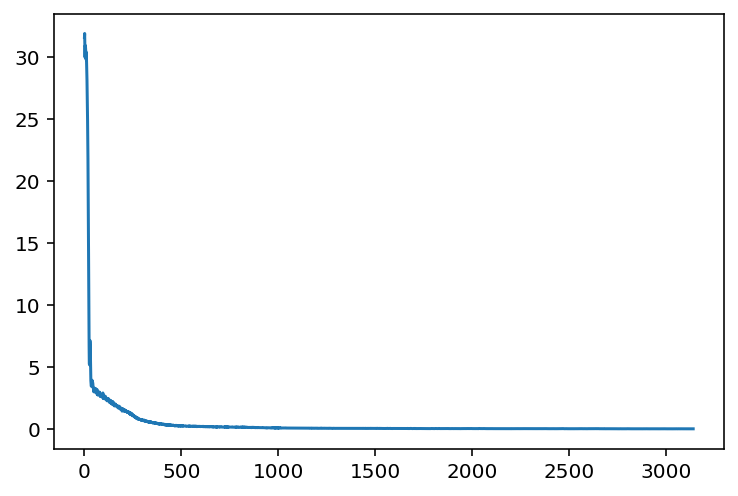

In [49]:
plt.plot(losses_c)
# plt.yscale("log")

### Iterating the map

Now that we've learned $X_{s,t}(x)$, we can iterate upon it to generate data, using a fixed number of iterations. 

We will do this with the following class called `MAP` which implements the iterative step and performs the rollout over the interval $t \in [0,1]$.

In [50]:
class MAP:
    def __init__(self, T, interpolant, n_step, rev = False):
        
        self.T           = T
        self.interpolant = interpolant
        self.n_step      = n_step
        self.ts          = torch.linspace(0.0,1.0, n_step + 1).to(device)
        if rev == True:
            self.ts = torch.flip(self.ts, dims=[0])   
    
    
    def step(self, x, s, t):
        return  self.T.Xst(x, s, t) 
    
    def solve(self, x_init):
        
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape)).to(device)
        x = x_init
        for i,t in enumerate(self.ts[:-1]):
            s = t.repeat(len(x)).to(device)
            t = self.ts[i+1].repeat(len(x))
            # print(s,t)
            x = self.step(x,s,t)
            xs[i] = x
        return xs

In [51]:
x_init = base.sample(20000).to(device)
T = T.to(device)

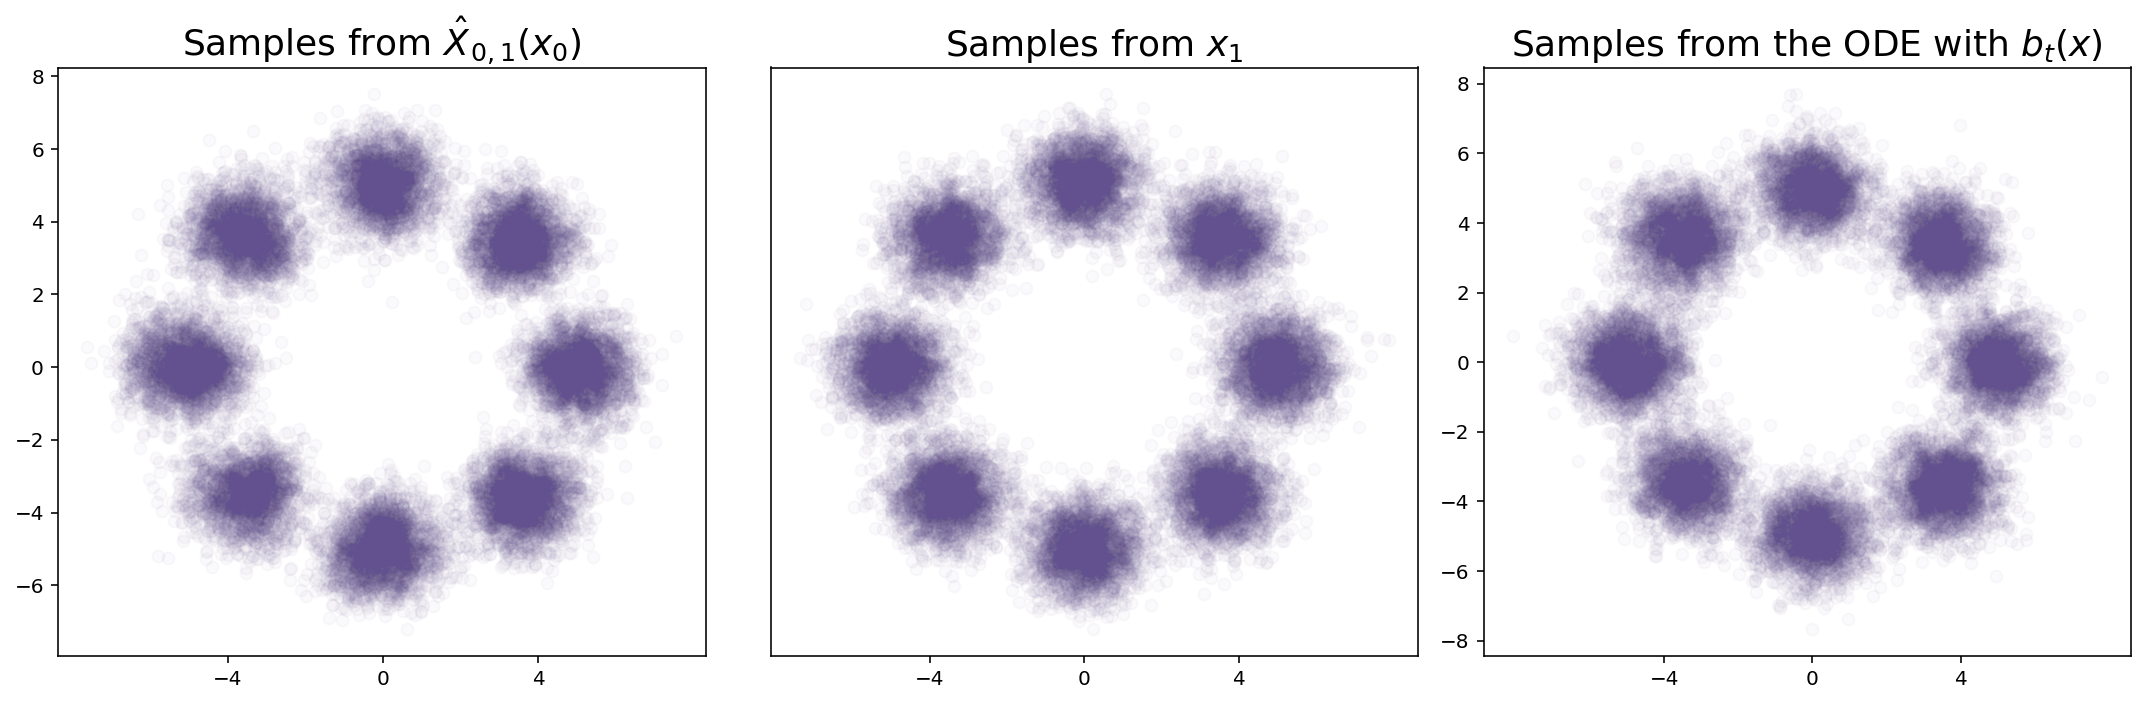

In [57]:
nstep_map = 4
map1  = MAP(T, interpolant, n_step = nstep_map)
xfs    = map1.solve(x_init)
x1s = xfs[-1].clone().detach().cpu().numpy()



# s0 = 0.0*torch.zeros(20000).to(device)
# t1 = 1.0*torch.ones(20000).to(device)

tt  = 1.0*torch.ones(20000)
x0se = base.sample(20000)
x1se = target(20000)
xtse = interpolant.xt(x0se, x1se, tt)


c = '#62508f' # plot color
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].scatter(x1s[:,0], x1s[:,1], alpha = 0.03, c = c)
axes[0].set_title(r"Samples from $\hat X_{0,1}(x_0)$", fontsize = 18)
axes[0].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[1].scatter(xtse[:,0], xtse[:,1], alpha = 0.03, c = c)
axes[1].set_title(r"Samples from $x_1$", fontsize = 18)
axes[1].set_xticks([-4,0,4]), axes[1].set_yticks([]);

axes[2].scatter(x1s_b[:,0], x1s_b[:,1], alpha = 0.03, c = c)
axes[2].set_title(r"Samples from the ODE with $b_t(x)$", fontsize = 18)
axes[2].set_xticks([-4,0,4]), axes[1].set_yticks([]);


plt.tight_layout()